In [1]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import * 
from pyspark.sql.types import *

In [63]:
# Define Spark schema for chess dataframe
chess_schema = StructType([
    StructField("event", StringType(), True),
    StructField("whiteplayerid", StringType(), True),
    StructField("blackplayerid", StringType(), True),
    StructField("gameoutcome", StringType(), True),
    StructField("gamedateutc", StringType(), True),
    StructField("gametimeutc", StringType(), True),
    StructField("whiteplayerelo", IntegerType(), True),
    StructField("blackplayerelo", IntegerType(), True),
    StructField("whiteratingchange", FloatType(), True),
    StructField("blackratingchange", FloatType(), True),
    StructField("openingeco", StringType(), True),
    StructField("openingname", StringType(), True),
    StructField("timecontrolseconds", StringType(), True),
    StructField("gameterminationreason", StringType(), True),
    StructField("movetext", StringType(), True)
])


In [64]:
# Defining the path to the CSV file in Google Cloud Storage
file_path = "gs://data-system-architecture-project/final_table/chess_games.csv"

# Read the CSV file into a Spark DataFrame
chess_df = spark.read.csv(file_path, header=True, schema = chess_schema)

In [65]:
# persisting dataframe
chess_df.persist()

23/12/09 23:20:13 WARN CacheManager: Asked to cache already cached data.


DataFrame[event: string, whiteplayerid: string, blackplayerid: string, gameoutcome: string, gamedateutc: string, gametimeutc: string, whiteplayerelo: int, blackplayerelo: int, whiteratingchange: float, blackratingchange: float, openingeco: string, openingname: string, timecontrolseconds: string, gameterminationreason: string, movetext: string]

In [66]:
chess_df.printSchema()

root
 |-- event: string (nullable = true)
 |-- whiteplayerid: string (nullable = true)
 |-- blackplayerid: string (nullable = true)
 |-- gameoutcome: string (nullable = true)
 |-- gamedateutc: string (nullable = true)
 |-- gametimeutc: string (nullable = true)
 |-- whiteplayerelo: integer (nullable = true)
 |-- blackplayerelo: integer (nullable = true)
 |-- whiteratingchange: float (nullable = true)
 |-- blackratingchange: float (nullable = true)
 |-- openingeco: string (nullable = true)
 |-- openingname: string (nullable = true)
 |-- timecontrolseconds: string (nullable = true)
 |-- gameterminationreason: string (nullable = true)
 |-- movetext: string (nullable = true)



In [67]:

#Transforming columns in chess_df for concise representation, including conditional logic for 
#GameOutcome" and casting "gamedateutc" to DateType.
transformed_df = chess_df.select(
    trim(col("event")).alias("Event"),
    trim(col("whiteplayerid")).alias("WhitePlayerID"),
    trim(col("blackplayerid")).alias("BlackPlayerID"),
    when(col("gameoutcome") == "1-0", "white")
    .when(col("gameoutcome") == "0-1", "black")
    .otherwise("draw").alias("Winner"),
    to_date(col("gamedateutc"), "yyyy.MM.dd").alias("GameDateUTC"),
    col("whiteplayerelo").alias("WhitePlayerELO"),
    col("blackplayerelo").alias("BlackPlayerELO"),
    col("whiteratingchange").alias("WhiteRatingChange"),
    col("blackratingchange").alias("BlackRatingChange"),
    col("openingname").alias("OpeningName"),
    col("timecontrolseconds").alias("TimeControlSeconds"),
    col("gameterminationreason").alias("GameTerminationReason")
)

In [68]:
transformed_df.printSchema()

root
 |-- Event: string (nullable = true)
 |-- WhitePlayerID: string (nullable = true)
 |-- BlackPlayerID: string (nullable = true)
 |-- Winner: string (nullable = false)
 |-- GameDateUTC: date (nullable = true)
 |-- WhitePlayerELO: integer (nullable = true)
 |-- BlackPlayerELO: integer (nullable = true)
 |-- WhiteRatingChange: float (nullable = true)
 |-- BlackRatingChange: float (nullable = true)
 |-- OpeningName: string (nullable = true)
 |-- TimeControlSeconds: string (nullable = true)
 |-- GameTerminationReason: string (nullable = true)



In [23]:
# grouping by year and Event and doing total game count 
Event_aggregated_df = transformed_df.groupBy(year("GameDateUTC").alias("Year"), "Event", "Winner") \
    .agg(count("Event").alias("TotalGames"))


In [69]:
#creating pandas dataframe from spark dataframe
winner_aggregated_pandas = Event_aggregated_df.groupBy(col("Winner")).agg(sum("TotalGames").alias("TotalGames")).toPandas()
print("Winning Percentage share of White and Black chess players")
print(winner_aggregated_pandas)


Winning Percentage share of White and Black chess players
  Winner  TotalGames
0  white     3113572
1  black     2902394
2   draw      240218


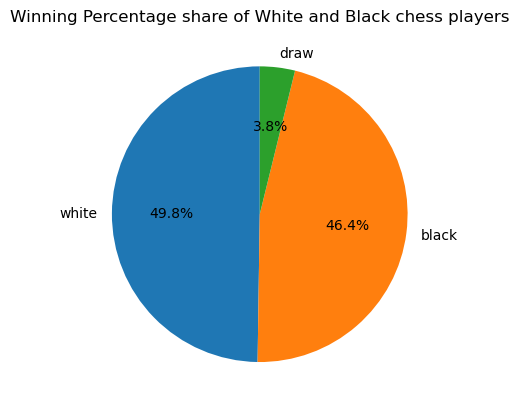

In [70]:
#plotting pie chart for winning percentage
labels = winner_aggregated_pandas["Winner"]
sizes = winner_aggregated_pandas["TotalGames"]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Winning Percentage share of White and Black chess players")
plt.show()

In [71]:
# aggregation to get Total Games by Event
event_aggregated_pandas = Event_aggregated_df.groupBy(col("Event")).agg(sum("TotalGames").alias("TotalGames")).toPandas()
print("Total Games by Event")
print(event_aggregated_pandas)

Total Games by Event
                  Event  TotalGames
0                Bullet     1198185
1  Classical tournament      165635
2     Bullet tournament      546777
3                 Blitz     2339574
4             Classical     1510811
5      Blitz tournament      472262
6        Correspondence       22940


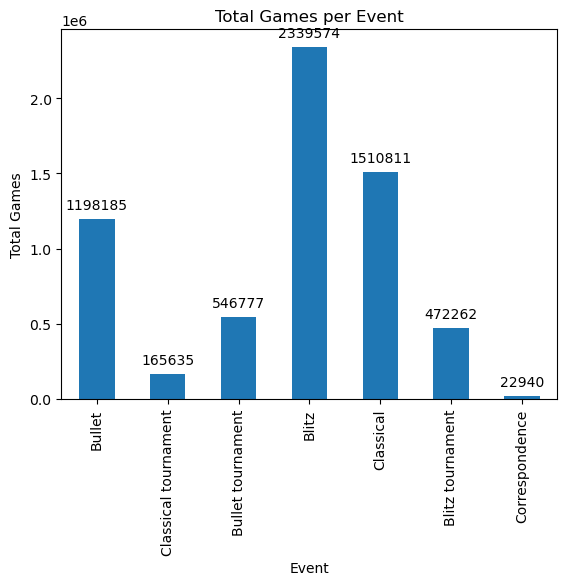

In [72]:
#plotting the bar chart for Total Games per Event

ax = event_aggregated_pandas.plot(kind='bar', x='Event', y='TotalGames', legend=False)
plt.title("Total Games per Event")
plt.xlabel("Event")
plt.ylabel("Total Games")

# Adding data labels in plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [74]:
from pyspark.sql.functions import col, when

#doing transofrmation and aggregation to get player statistics

# Selecting relevant columns and apply conditions for white players
white_players_df = transformed_df.filter(col("WhitePlayerID") != col("BlackPlayerID")).select(
    col("WhitePlayerID").alias("PlayerID"),
    col("WhitePlayerELO").alias("PlayerELO"),
    when(col("Winner") == "white", 1).otherwise(0).alias("DidWin"),
    when(col("Winner") == "black", 1).otherwise(0).alias("DidLose"),
    when(col("Winner") == "draw", 1).otherwise(0).alias("DidDraw")
)

# Select relevant columns and apply conditions for black players
black_players_df = transformed_df.filter(col("WhitePlayerID") != col("BlackPlayerID")).select(
    col("BlackPlayerID").alias("PlayerID"),
    col("BlackPlayerELO").alias("PlayerELO"),
    when(col("Winner") == "black", 1).otherwise(0).alias("DidWin"),
    when(col("Winner") == "white", 1).otherwise(0).alias("DidLose"),
    when(col("Winner") == "draw", 1).otherwise(0).alias("DidDraw")
)

# Union the DataFrames to create players_df
players_df = white_players_df.union(black_players_df)

# Group by PlayerID and aggregate the required statistics
players_agg_df = players_df.groupBy("PlayerID").agg(
    sum("DidWin").alias("TotalWins"),
    sum("DidLose").alias("TotalLose"),
    sum("DidDraw").alias("TotalDraws"),
    max("PlayerELO").alias("HighestRating"),
    min("PlayerELO").alias("LowestRating"),
    round(avg("PlayerELO")).cast("int").alias("AverageRating")
)
players_agg_df = players_agg_df.withColumn(
    "WinningPercentage", round((col("TotalWins") * 100) / (col("TotalWins") + col("TotalLose") + col("TotalDraws"))).cast("int")
)
print("printing chess player statistics")
players_agg_df.show(5)


printing chess player statistics


+-------------+---------+---------+----------+-------------+------------+-------------+-----------------+
|     PlayerID|TotalWins|TotalLose|TotalDraws|HighestRating|LowestRating|AverageRating|WinningPercentage|
+-------------+---------+---------+----------+-------------+------------+-------------+-----------------+
|         zobe|       30|       58|         1|         1566|        1413|         1484|               34|
|aimevenhigher|       53|       15|         7|         2222|        1500|         2034|               71|
|     ziliboba|      144|      205|        22|         2034|        1545|         1911|               39|
| EESSLLAAMM40|      211|     1580|        21|         1634|        1184|         1317|               12|
|    alekstone|      937|      534|        65|         1809|        1543|         1701|               61|
+-------------+---------+---------+----------+-------------+------------+-------------+-----------------+
only showing top 5 rows



In [75]:
# Getting top 10 players which has highest average rating 
top_10_players_df = players_agg_df.select("PlayerID", "AverageRating") \
    .orderBy("AverageRating", ascending=False) \
    .limit(10)
print("Top 10 players with highest AverageRating")
top_10_players_df.show()

Top 10 players with highest AverageRating


+---------------+-------------+
|       PlayerID|AverageRating|
+---------------+-------------+
|UnVieuxMonsieur|         3079|
|    penguingim1|         2860|
|BeepBeepImAJeep|         2818|
|       jitanu76|         2757|
|       hiimgosu|         2755|
|          gnejs|         2753|
|     KyleKorver|         2745|
|    zvonokchess|         2738|
|         thujer|         2730|
|    BahadirOzen|         2716|
+---------------+-------------+



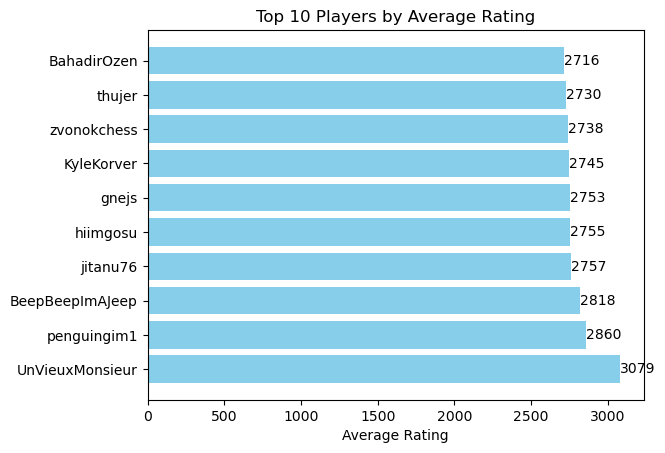

In [76]:
# Convert to Pandas DataFrame
top_10_players_pandas = top_10_players_df.toPandas()

# Plot horizontal bars with data labels
fig, ax = plt.subplots()
bars = ax.barh(top_10_players_pandas["PlayerID"], top_10_players_pandas["AverageRating"], color='skyblue')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', 
             va='center', ha='left', color='black', fontsize=10)

plt.xlabel("Average Rating")
plt.title("Top 10 Players by Average Rating")
plt.show()

In [78]:
# Select the top players based on AverageRating
top_players_df = players_agg_df.select("PlayerID", "TotalWins", "TotalLose", "TotalDraws") \
    .orderBy("AverageRating", ascending=False) \
    .limit(10)
print("Top 10 players with their total wins,lose and draws")
top_players_df.show()

Top 10 players with their total wins,lose and draws


+---------------+---------+---------+----------+
|       PlayerID|TotalWins|TotalLose|TotalDraws|
+---------------+---------+---------+----------+
|UnVieuxMonsieur|       30|        1|         0|
|    penguingim1|      256|       54|        10|
|BeepBeepImAJeep|       23|        0|         0|
|       jitanu76|       70|       17|        12|
|       hiimgosu|      191|       38|         7|
|          gnejs|      647|      164|        36|
|     KyleKorver|      519|      119|        26|
|    zvonokchess|        7|        2|         5|
|         thujer|        0|        0|         1|
|    BahadirOzen|       12|        4|         1|
+---------------+---------+---------+----------+



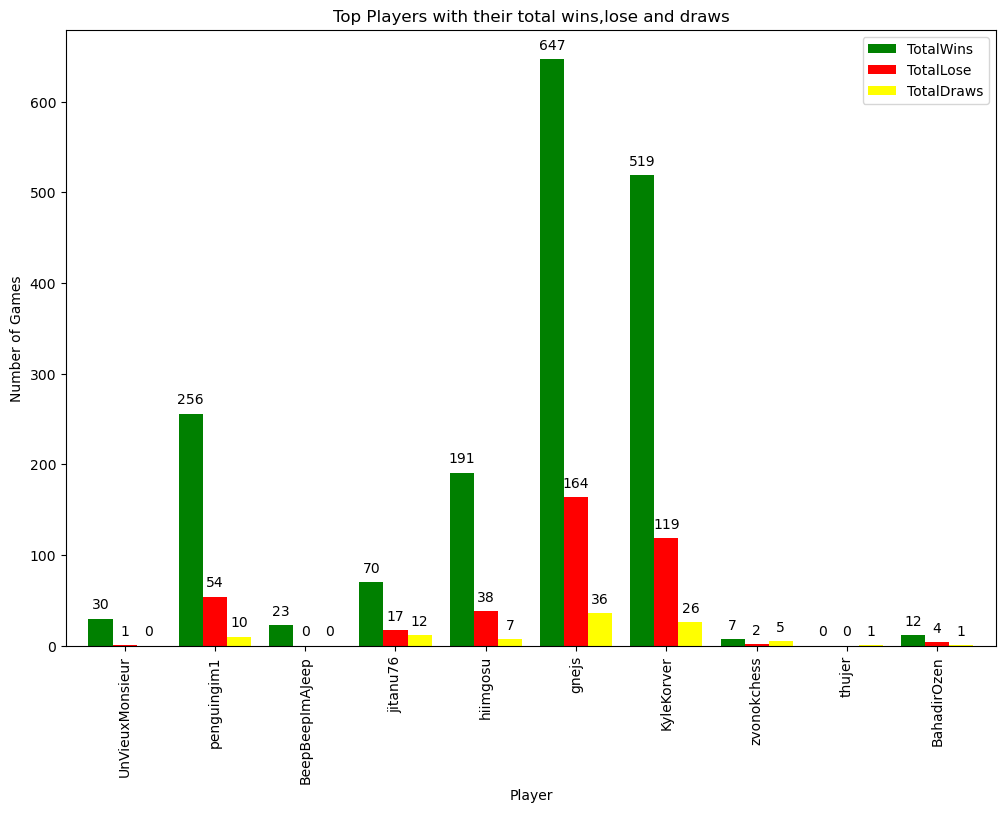

In [79]:
# Convert to Pandas DataFrame for bar plot
top_players_pandas = top_players_df.toPandas()

# Set the PlayerID as the index for better plotting
top_players_pandas.set_index("PlayerID", inplace=True)

# Define custom colors for TotalWins, TotalLose, and TotalDraws
colors = {'TotalWins': 'green', 'TotalLose': 'red', 'TotalDraws': 'yellow'}

# Plot vertical clustered bars with custom colors
ax = top_players_pandas[['TotalWins', 'TotalLose', 'TotalDraws']].plot(kind='bar', width=0.8, color=[colors[col] for col in top_players_pandas.columns], figsize=(12, 8))

# Add data labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add labels and title
plt.xlabel("Player")
plt.ylabel("Number of Games")
plt.title("Top Players with their total wins,lose and draws")

# Show the plot
plt.show()